# **CSC - Predict Returns**

### **1) Problem statement**

Included are two files: train.csv and test.csv. Each contains synthetically generated transactions from an imaginary clothing retailer located in the USA.
Each row represents a line item from a specific online order. Everything that is required to make a good model is already in here.

Each product that is sold by this retailer is unique on ProductDepartment, ProductCost and MSRP. MSRP can be recovered using DiscountPct and PurchasePrice columns.
Using the transactions in the train.csv file, train a model that will calculate the probability that a transaction results in a return. Score the rows in the test.csv file using the model.

Submission will be evaluated on ROC AUC. If the submission meets the ROC AUC score threshold, an additional evaluation will be done using Brier score to test calibration.

### **2) Data Collection**

**Import packages**




In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

**Read training dataset and view top 5 rows**

In [34]:
df = pd.read_csv('../data/train.csv')
df.head()

,ID,OrderID,CustomerID,CustomerState,CustomerBirthDate,OrderDate,ProductDepartment,ProductSize,ProductCost,DiscountPct,PurchasePrice,Returned
0,58334388-e72d-40d3-afcf-59561c262e86,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Youth,M,9,0.0356,28.93,0
1,fb73c186-ca70-4eea-b80e-422d732205aa,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,L,17,0.1192,44.92,0
2,7590dca6-7344-4a11-ad6e-bd9100730c33,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,XL,20,0.1698,48.98,0
3,cb8cf8da-ef31-4b6f-b515-3a7f75d17d0f,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,L,17,0.1973,51.37,0
4,b7d5f19d-ebf0-48c1-afb2-4f066cb5f04e,ce1867af-0846-4352-bdda-465e88c2c2ed,19c8c37f-d1ab-488e-848c-c28ba9c5d80c,Indiana,1979-01-11,2016-01-11,Womens,XS,42,0.0663,113.91,0


**Check data types**

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64912 entries, 0 to 64911
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 64912 non-null  object 
 1   OrderID            64912 non-null  object 
 2   CustomerID         64912 non-null  object 
 3   CustomerState      64912 non-null  object 
 4   CustomerBirthDate  64912 non-null  object 
 5   OrderDate          64912 non-null  object 
 6   ProductDepartment  64912 non-null  object 
 7   ProductSize        64912 non-null  object 
 8   ProductCost        64912 non-null  int64  
 9   DiscountPct        64912 non-null  float64
 10  PurchasePrice      64912 non-null  float64
 11  Returned           64912 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 5.9+ MB


**Add and modify columns**





1.   Modify date columns from string to datetime.
2.   Add new column for MSRP based on PurchasePrice and DiscountPct.
3.   Add new column for ProductID that is unique on ProductDepartment, ProducCost and MSRP.






In [36]:
df['CustomerBirthDate'] = pd.to_datetime(df['CustomerBirthDate'])
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['MSRP'] = (df['PurchasePrice'] / (1 - df['DiscountPct'])).round()
df['ProductID'] = df['ProductDepartment'] + '_' + df['ProductCost'].astype(str) + '_' + df['MSRP'].astype(str)
df['MSRPNotRounded'] = (df['PurchasePrice'] / (1 - df['DiscountPct']))
df['ProductIDNotRounded'] = df['ProductDepartment'] + '_' + df['ProductCost'].astype(str) + '_' + df['MSRPNotRounded'].astype(str)
df.head()

,ID,OrderID,CustomerID,CustomerState,CustomerBirthDate,OrderDate,ProductDepartment,ProductSize,ProductCost,DiscountPct,PurchasePrice,Returned,MSRP,ProductID,MSRPNotRounded,ProductIDNotRounded
0,58334388-e72d-40d3-afcf-59561c262e86,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Youth,M,9,0.0356,28.93,0,30.0,Youth_9_30.0,29.997926,Youth_9_29.99792617171298
1,fb73c186-ca70-4eea-b80e-422d732205aa,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,L,17,0.1192,44.92,0,51.0,Mens_17_51.0,50.999092,Mens_17_50.99909173478656
2,7590dca6-7344-4a11-ad6e-bd9100730c33,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,XL,20,0.1698,48.98,0,59.0,Mens_20_59.0,58.997832,Mens_20_58.99783184774753
3,cb8cf8da-ef31-4b6f-b515-3a7f75d17d0f,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,L,17,0.1973,51.37,0,64.0,Mens_17_64.0,63.996512,Mens_17_63.99651177276691
4,b7d5f19d-ebf0-48c1-afb2-4f066cb5f04e,ce1867af-0846-4352-bdda-465e88c2c2ed,19c8c37f-d1ab-488e-848c-c28ba9c5d80c,Indiana,1979-01-11,2016-01-11,Womens,XS,42,0.0663,113.91,0,122.0,Womens_42_122.0,121.998501,Womens_42_121.9985005890543


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64912 entries, 0 to 64911
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   64912 non-null  object        
 1   OrderID              64912 non-null  object        
 2   CustomerID           64912 non-null  object        
 3   CustomerState        64912 non-null  object        
 4   CustomerBirthDate    64912 non-null  datetime64[ns]
 5   OrderDate            64912 non-null  datetime64[ns]
 6   ProductDepartment    64912 non-null  object        
 7   ProductSize          64912 non-null  object        
 8   ProductCost          64912 non-null  int64         
 9   DiscountPct          64912 non-null  float64       
 10  PurchasePrice        64912 non-null  float64       
 11  Returned             64912 non-null  int64         
 12  MSRP                 64912 non-null  float64       
 13  ProductID            64912 non-

**Total rows and columns**

In [38]:
df.shape

(64912, 16)

**Check missing values**

In [39]:
df.isna().sum()

ID                     0
OrderID                0
CustomerID             0
CustomerState          0
CustomerBirthDate      0
OrderDate              0
ProductDepartment      0
ProductSize            0
ProductCost            0
DiscountPct            0
PurchasePrice          0
Returned               0
MSRP                   0
ProductID              0
MSRPNotRounded         0
ProductIDNotRounded    0
dtype: int64

**Check duplicates**

In [40]:
df.duplicated().sum()

0

**Check number of unique values in each column**



In [41]:
df.nunique()

ID                     64912
OrderID                21178
CustomerID              6300
CustomerState             51
CustomerBirthDate       5270
OrderDate               1741
ProductDepartment          4
ProductSize                7
ProductCost               45
DiscountPct              133
PurchasePrice           2052
Returned                   2
MSRP                     111
ProductID                195
MSRPNotRounded          2192
ProductIDNotRounded     3760
dtype: int64

In [42]:
df = df.drop('MSRPNotRounded', axis=1)
df = df.drop('ProductIDNotRounded', axis=1)

**Check statistics**



In [43]:
df.describe()

,CustomerBirthDate,OrderDate,ProductCost,DiscountPct,PurchasePrice,Returned,MSRP
count,64912,64912,64912.000000,64912.000000,64912.000000,64912.000000,64912.000000
mean,1974-06-04 15:33:09.894010368,2018-08-17 12:47:04.451565312,26.012001,0.168893,65.423903,0.352431,78.508750
min,1946-03-11 00:00:00,2016-01-06 00:00:00,3.000000,0.001900,8.730000,0.000000,13.000000
25%,1962-11-25 00:00:00,2017-07-09 00:00:00,18.000000,0.088200,44.790000,0.000000,55.000000
50%,1975-10-17 00:00:00,2018-09-08 00:00:00,25.000000,0.171700,62.540000,0.000000,77.000000
75%,1986-09-04 00:00:00,2019-10-01 00:00:00,33.000000,0.254100,84.840000,1.000000,102.000000
max,1996-08-05 00:00:00,2020-12-31 00:00:00,59.000000,0.332900,132.720000,1.000000,133.000000
std,NaN,NaN,11.987423,0.095567,26.167467,0.477731,29.164631


In [44]:
max_order_date = df['OrderDate'].max()
max_customer_birth_date = df['CustomerBirthDate'].max()

# Display the results
print("Max OrderDate:", df['OrderDate'].max())
print("Min OrderDate:", df['OrderDate'].min())
print("Max CustomerBirthDate:", df['CustomerBirthDate'].max())
print("Min CustomerBirthDate:", df['CustomerBirthDate'].min())

Max OrderDate: 2020-12-31 00:00:00
Min OrderDate: 2016-01-06 00:00:00
Max CustomerBirthDate: 1996-08-05 00:00:00
Min CustomerBirthDate: 1946-03-11 00:00:00


### **3) Explore data**

In [45]:
df.head()

,ID,OrderID,CustomerID,CustomerState,CustomerBirthDate,OrderDate,ProductDepartment,ProductSize,ProductCost,DiscountPct,PurchasePrice,Returned,MSRP,ProductID
0,58334388-e72d-40d3-afcf-59561c262e86,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Youth,M,9,0.0356,28.93,0,30.0,Youth_9_30.0
1,fb73c186-ca70-4eea-b80e-422d732205aa,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,L,17,0.1192,44.92,0,51.0,Mens_17_51.0
2,7590dca6-7344-4a11-ad6e-bd9100730c33,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,XL,20,0.1698,48.98,0,59.0,Mens_20_59.0
3,cb8cf8da-ef31-4b6f-b515-3a7f75d17d0f,4fc2f4ea-7098-4e9d-87b1-52b6a9ee21fd,c401d50e-37b7-45ea-801a-d71c13ea6387,Kentucky,1967-01-06,2016-01-06,Mens,L,17,0.1973,51.37,0,64.0,Mens_17_64.0
4,b7d5f19d-ebf0-48c1-afb2-4f066cb5f04e,ce1867af-0846-4352-bdda-465e88c2c2ed,19c8c37f-d1ab-488e-848c-c28ba9c5d80c,Indiana,1979-01-11,2016-01-11,Womens,XS,42,0.0663,113.91,0,122.0,Womens_42_122.0


In [46]:
print(f"Product Departments: {df['ProductDepartment'].unique()}")
print(f"Product Sizes: {df['ProductSize'].unique()}")

tot_unknown_productsize = len(df['ProductSize'] == '~')
print(f"Transactions with unknown Product Size = '~': {tot_unknown_productsize}")
print(f"- Ratio of returned tx = {len(df[(df['ProductSize'] == '~') & (df['Returned'] == 1)])/tot_unknown_productsize}")
print(f"- Ratio of non-returned tx = {len(df[(df['ProductSize'] == '~') & (df['Returned'] == 0)])/tot_unknown_productsize}")

Product Departments: ['Youth' 'Mens' 'Womens' 'Accessories']
Product Sizes: ['M' 'L' 'XL' 'XS' 'XXL' 'S' '~']
Transactions with unknown Product Size = '~': 64912
- Ratio of returned tx = 0.0077489524279023905
- Ratio of non-returned tx = 0.05313347300961301


In [47]:
thresh = 5
returned_rows = df[df['Returned'] == 1]
customer_return_counts = returned_rows['CustomerID'].value_counts()
returned_count = customer_return_counts[customer_return_counts > thresh]
print(f"Number of customers that returned more than {thresh} times: \n{len(returned_count)}")

Number of customers that returned more than 5 times: 
1392


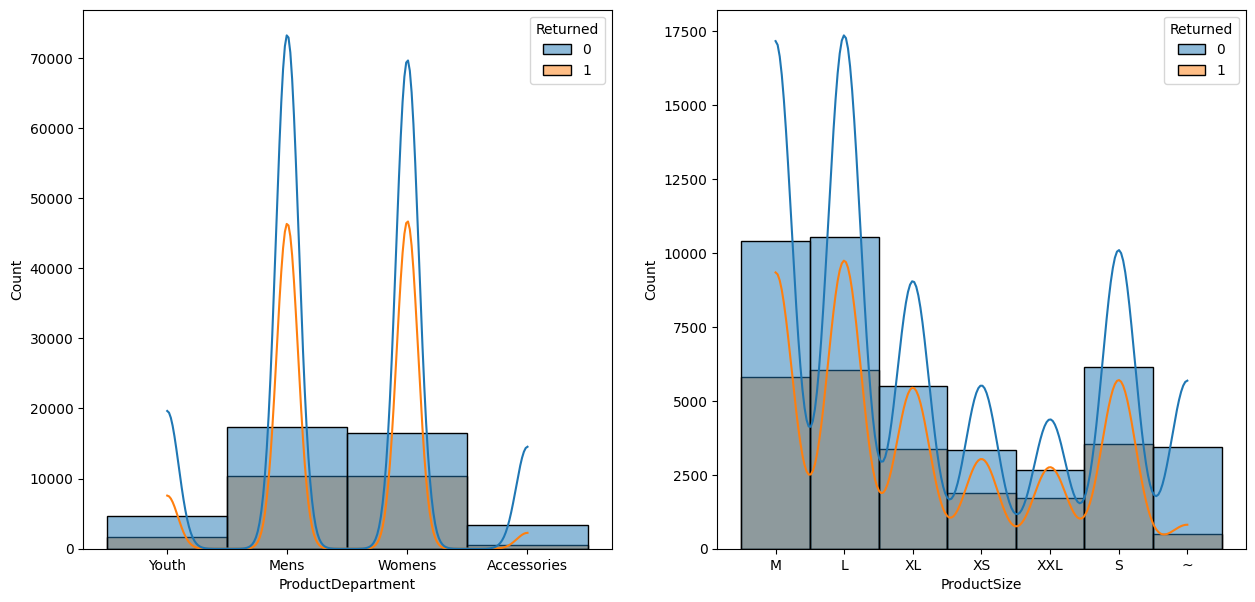

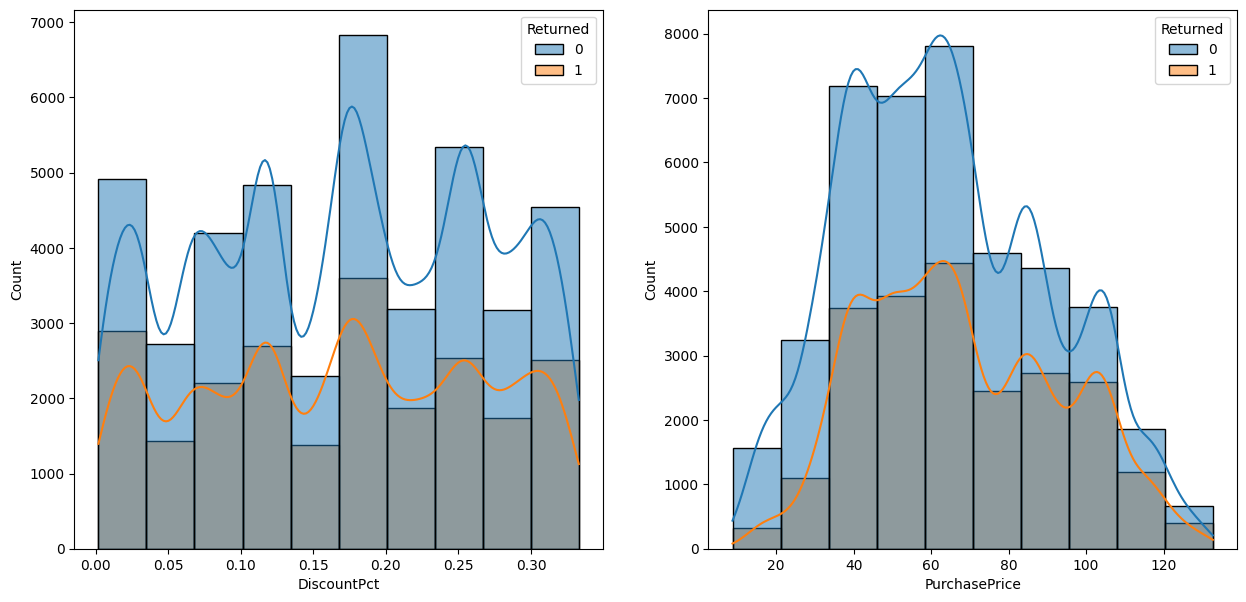

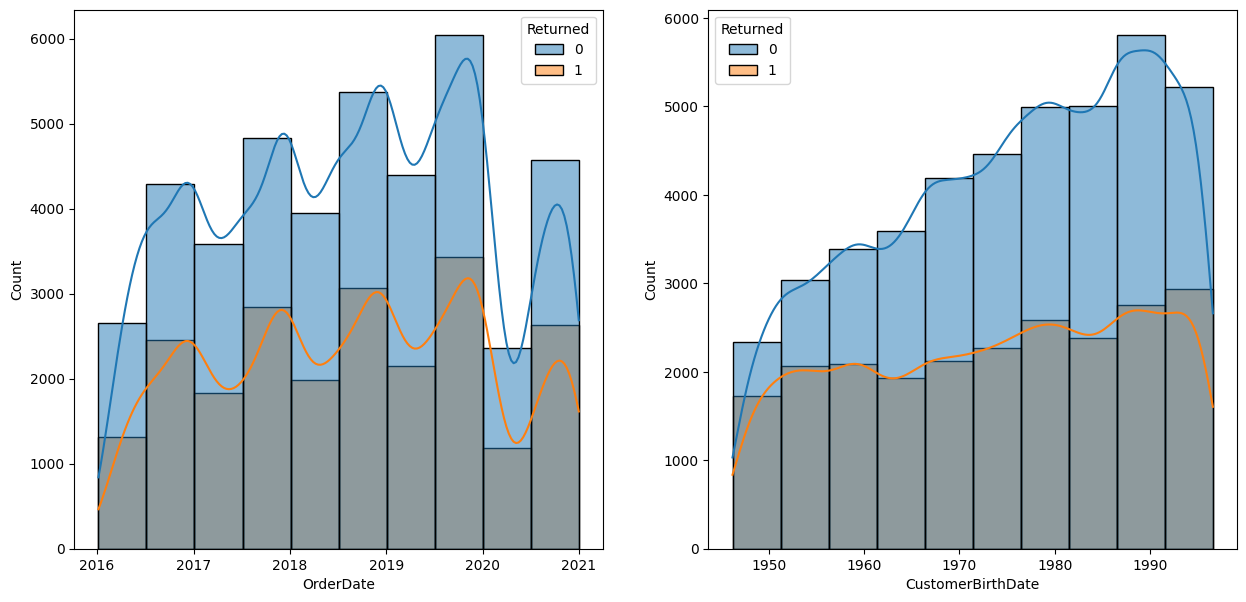

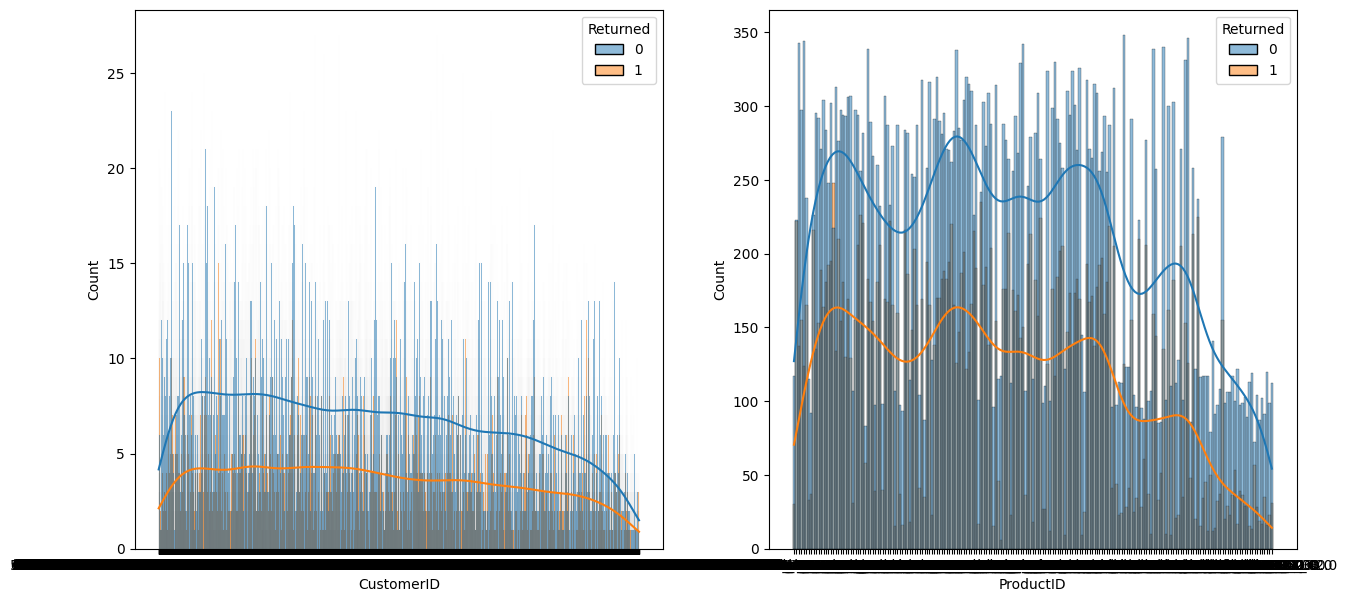

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df,x='ProductDepartment', kde=True,hue='Returned')
plt.subplot(122)
sns.histplot(data=df,x='ProductSize',bins=10, kde=True,hue='Returned')

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df,x='DiscountPct', bins=10, kde=True,hue='Returned')
plt.subplot(122)
sns.histplot(data=df,x='PurchasePrice', bins=10, kde=True,hue='Returned')

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df,x='OrderDate', bins=10, kde=True,hue='Returned')
plt.subplot(122)
sns.histplot(data=df,x='CustomerBirthDate', bins=10, kde=True,hue='Returned')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df,x='CustomerID', bins=10, kde=True,hue='Returned')
plt.subplot(122)
sns.histplot(data=df,x='ProductID', bins=10, kde=True,hue='Returned')
plt.show()

In [49]:
group_by_states = df.groupby('CustomerState')['Returned'].mean().sort_values(ascending=False)
print(f"Average returns by State: \n{group_by_states}")

Average returns by State: 
CustomerState
Delaware          0.408537
Alabama           0.383648
North Carolina    0.382251
Indiana           0.378566
Mississippi       0.376623
Tennessee         0.372624
Georgia           0.372284
West Virginia     0.368243
Oregon            0.367879
Texas             0.367736
Nevada            0.367089
Wisconsin         0.364519
Iowa              0.363636
Vermont           0.362069
South Dakota      0.361386
North Dakota      0.360465
Connecticut       0.360284
Montana           0.357692
Maryland          0.356905
Arizona           0.356863
Rhode Island      0.355670
Minnesota         0.355109
Massachusetts     0.354572
Pennsylvania      0.352964
Idaho             0.352381
Illinois          0.351824
Washington        0.351711
New Jersey        0.351648
Florida           0.351226
Virginia          0.349697
Arkansas          0.346093
Hawaii            0.345528
New York          0.344828
California        0.343799
New Hampshire     0.340807
Colorado      

### **4) EDA Insights**

   - As indicated in the requirement, implemented the creation of a unique `ProductID` column based on `ProductDepartment`, `ProductCost`, and `MSRP`.
   - Calculated the `MSRP` by utilizing `DiscountPct` and `PurchasePrice` columns.
   - **Note:** If the MSRP is not rounded to the nearest integer, it generates around `3760` unique ProductIDs as compared to `195`. The latter seems correct.
   - Identified instances of `OrderID`, `ProductID` combinations with only Return records (`Returned = 1`) or coexistence of Purchase (`Returned = 0`) and Return records.
   - **Note:** The decision is to disregard these anomalies as part of the dataset's synthetic nature.
   - Date columns of type string must be transformed to datetime format.
   - Customer age can be derived from `CustomerBirthDate` and `OrderDate`
   - Columns such as `ID` and `OrderDate` offer no contribution to the target variable.
     **Note:** The `OrderDate` would have been relevant if the orders were recent and if the minimum return day policy had been stipulated in the requirement.